# Analyzing Monte Carlo Simulations

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_csv("data/mc_dac.txt", sep=" +", engine='python')
data.columns = ["net1", "iout", "idump"]
data["bit"] = data.index
data.head()

,net1,iout,idump,bit
0,0.032433,1.384939e-07,1.090820e-06,0
1,0.014943,5.840238e-07,6.420400e-07,1
2,0.014929,5.842548e-07,6.418090e-07,2
3,0.014550,5.959371e-07,6.301234e-07,3
4,0.014900,5.847123e-07,6.413515e-07,4


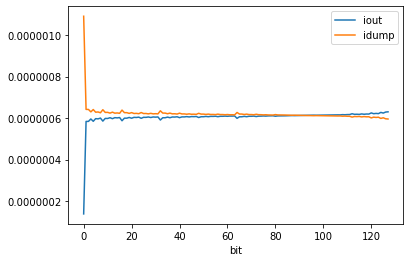

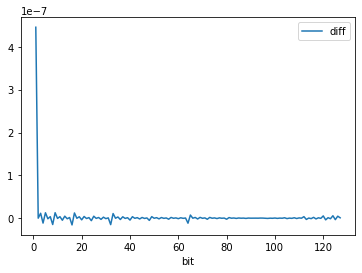

In [19]:
data.plot("bit", ["iout", "idump"])

data["diff"] = data["iout"].diff(1)

data.plot("bit", "diff")